# Prostate cancer dataset with multiple overlapping field-of-views

We will see an example of to convert a complex multi-field-of-view dataset into Zarr. The converted data will be easier to visualize and analyze, and will contain all the information regarding the spatial alignments.

In [1]:
%load_ext jupyter_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import hashlib
import json
import os
import shutil
import zipfile
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import spatialdata_plot
from anndata import AnnData
from dask_image.imread import imread

# from napari_spatialdata import Interactive
from spatial_image import SpatialImage
from spatialdata import SpatialData, concatenate
from spatialdata.models import Image2DModel, ShapesModel, TableModel
from spatialdata.transformations import (
    Identity,
    Scale,
    align_elements_using_landmarks,
    get_transformation,
    set_transformation,
)
from spatialdata_io.readers._utils._read_10x_h5 import _read_10x_h5
from tqdm import tqdm

PIL.Image.MAX_IMAGE_PIXELS = None

/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/l989o/dependencies/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


This notebook performs some data conversion steps that are computational expensive. To make it easier to re-run this notebook without having to re-perform those task, we use a set of flags.

To run the full notebook, set all the flags to `False`. Running it should take ~1 hour, with most of the processing time due to the conversion of the large images.

In [4]:
RAW_DATA_ALREADY_UNZIPPED = os.environ.get("RAW_DATA_ALREADY_UNZIPPED", "True") == "True"
IMAGES_ALREADY_CONVERTED = os.environ.get("IMAGES_ALREADY_CONVERTED", "True") == "True"
EXPRESSION_ALREADY_CONVERTED = os.environ.get("EXPRESSION_ALREADY_CONVERTED", "True") == "True"

In [ ]:
print(f"RAW_DATA_ALREADY_UNZIPPED: {RAW_DATA_ALREADY_UNZIPPED}")
print(f"IMAGES_ALREADY_CONVERTED: {IMAGES_ALREADY_CONVERTED}")
print(f"EXPRESSION_ALREADY_CONVERTED: {EXPRESSION_ALREADY_CONVERTED}")

## Overview of the raw data

Please manually download the data from https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/svw96g68dv-1.zip, and make it accesible from this notebook by putting it in `./data/lundeberg`. You can also use symlinks to make that path available to this notebook.

In [6]:
LUNDEBERG_DATA_ROOT = "data/lundeberg"
if not RAW_DATA_ALREADY_UNZIPPED:
    path = os.path.join(LUNDEBERG_DATA_ROOT, "svw96g68dv-1.zip")
    assert os.path.isfile(path)
else:
    path = os.path.join(LUNDEBERG_DATA_ROOT, "svw96g68dv-1")
    assert os.path.isdir(path)

In [7]:
# unzip the data
unzipped_path = path.replace(".zip", "")
if not RAW_DATA_ALREADY_UNZIPPED:
    CHECKSUM = "eebd948d752a6d16b9c972e3fc4b293c4fa0fc16edbcbec41c8c5d48acf2143b"

    if hashlib.sha256(open(path, "rb").read()).hexdigest() != CHECKSUM:
        print("checksum mismatch")
    else:
        print("checksum ok")

    if not os.path.exists(unzipped_path):
        print("Unzipping the data")
        with zipfile.ZipFile(path) as zip_ref:
            zip_ref.extractall(os.path.dirname(unzipped_path))
        print("data unzipped")
    assert os.path.isdir(unzipped_path)

The dataset contains several files.

In [8]:
!tree $unzipped_path -L 1

data/lundeberg/svw96g68dv-1
├── Additional_figures
├── Count_matrices
├── DEG_analyses_lists_(Prostate_P1_H2_1)
├── Histological_images
├── inferCNV_pediatric_patient_1
├── p63_AMACR_stains_prostate
├── SCC_patient
├── Stereoscope_cell_typ
├── Synthethic_data
└── WGS_SNP_prostate

10 directories, 0 files


We will load and convert the following to NGFF:
* data layout schematics, from `Additional_figures`
* large H&E images for the Visium data (`patient1_visium`, `patient2_visium`) and for the 1K data (`patient1_1k`), from `Histological_images`
* Visium and 1k expression matrices, from `Count_matrices`

Together, the above data amounts for a large fraction of the files of the dataset.

In [9]:
!tree $unzipped_path

data/lundeberg/svw96g68dv-1
├── Additional_figures
│   ├── Patient_1_1k_Spatial_QC_Plot.png
│   ├── Patient_1_H1_1_&_V1_1_iCNV.png
│   ├── Patient_1_H2_1_Unsupervised_iCNV.png
│   ├── Patient_1_Visium_Spatial_QC_Plot.png
│   ├── Patient_1_Visium_Spot_Histology.png
│   ├── Patient_2_Visium_Spatial_QC_Plot.png
│   ├── Prostate_Patient_1.png
│   ├── Prostate_Patient_2.png
│   ├── SCC_smFISH_gain_of_1q_clones_A_B_C_and_normal_copy_clone_D_plus_amp.png
│   ├── SCC_smFISH_loss_of_8q_clones_A_B_D_normal_copy_clone_C.png
│   ├── Spatial_GEFs_Patient_1_1k.png
│   ├── Spatial_GEFs_Patient_1_Visium.png
│   └── Spatial_GEFs_Patient_2_Visium.png
├── Count_matrices
│   ├── Patient\ 1
│   │   ├── 1k_arrays
│   │   │   ├── H1_1
│   │   │   │   ├── 180822_L11_CN57_E1_H1.1_EB_stdata.tsv
│   │   │   │   └── spot_data-selection-180822_L11_CN57_E1_P_H1.1_CY3_EB_aliged.tsv
│   │   │   ├── H1_2
│   │   │   │   ├── 180903_L11_CN51_C2_H1.2_EB_stdata.tsv
│   │   │   │   └── spot_data-selection-180903_L11_CN51_C

## Converting the images

### Layout images (small images)

In [10]:
layout_images = {
    "patient1_visium": os.path.join(unzipped_path, "Additional_figures/Spatial_GEFs_Patient_1_Visium.png"),
    "patient2_visium": os.path.join(unzipped_path, "Additional_figures/Spatial_GEFs_Patient_2_Visium.png"),
    "patient1_1k": os.path.join(unzipped_path, "Additional_figures/Spatial_GEFs_Patient_1_1k.png"),
}

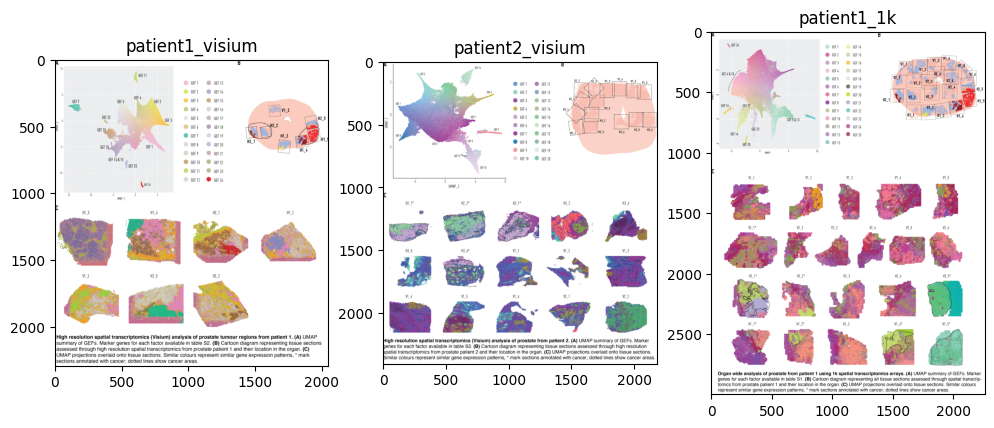

In [11]:
axes = plt.subplots(1, 3, figsize=(12, 5))[1].flatten()

for ax, (key, value) in zip(axes, layout_images.items()):
    im = np.squeeze(imread(value).compute(), 0)
    layout_images[key] = im
    ax.imshow(im)
    ax.set_title(key)

We are just interested in the schematics in the top right corner, let's crop the images. We manually identified the coordinates from an image viewer. You can for instance use napari, Fiji, Photoshop.

In [12]:
layout_images["patient1_visium"] = layout_images["patient1_visium"][293:732, 1423:2052]
layout_images["patient2_visium"] = layout_images["patient2_visium"][124:750, 1426:2181]
layout_images["patient1_1k"] = layout_images["patient1_1k"][176:744, 1403:2261]

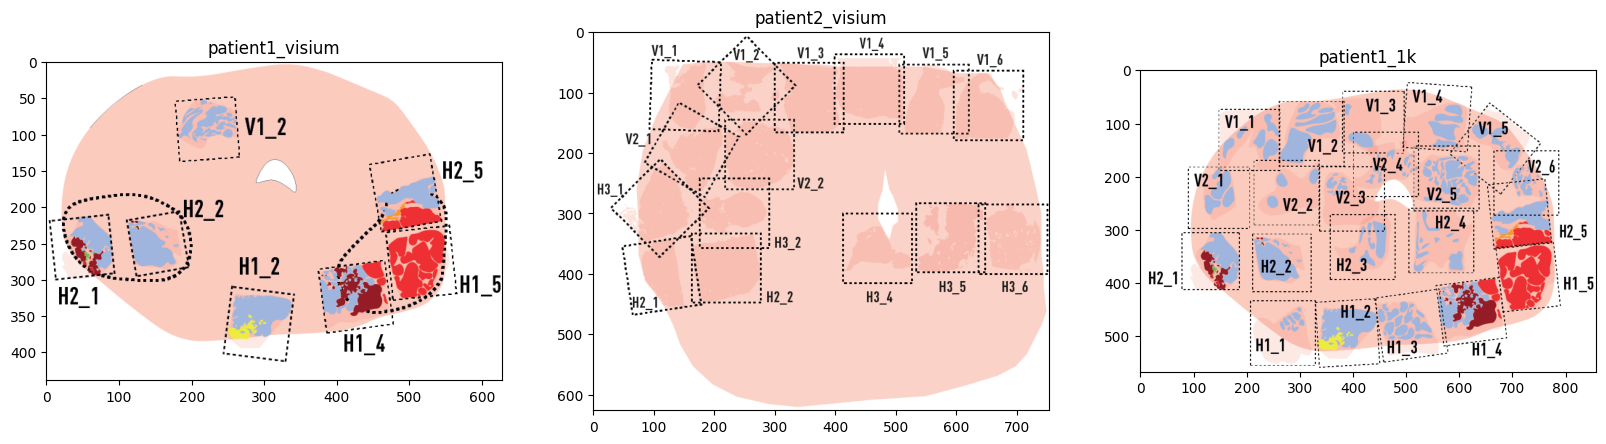

In [13]:
axes = plt.subplots(1, 3, figsize=(20, 5))[1].flatten()

for ax, (key, value) in zip(axes, layout_images.items()):
    ax.imshow(layout_images[key])
    ax.set_title(key)

### H&E images, `patient1_visium` (large images)

Here we will load large H&E images. We will use `dask_image.imread()` to be able to lazily represent the data even in a low-memory system (laptop).

In [14]:
if not IMAGES_ALREADY_CONVERTED:
    large_images = {}
    for name in tqdm(os.listdir(os.path.join(unzipped_path, "Histological_images/Patient_1/Visium/"))):
        if name.endswith(".jpg"):
            path = os.path.join(unzipped_path, "Histological_images/Patient_1/Visium/", name)
            sample_name = name.replace(".jpg", "") + "_patient1_visium"

            im = imread(path)
            im = im.squeeze()
            im = Image2DModel.parse(
                im, dims=("y", "x", "c"), scale_factors=[2, 2, 2, 2], transformations={sample_name: Identity()}
            )

            large_images[sample_name] = im

Now let's place the images, together with the small layout image, in a `SpatialData` object.

In [15]:
if not IMAGES_ALREADY_CONVERTED:
    layout_image = Image2DModel.parse(
        layout_images["patient1_visium"], dims=("y", "x", "c"), transformations={"patient1_visium": Identity()}
    )
    sdata_patient1_visium = SpatialData(images={"layout_patient1_visium": layout_image} | large_images)

### H&E images, patient2_visium (large images)

In [16]:
if not IMAGES_ALREADY_CONVERTED:
    large_images = {}
    for name in tqdm(os.listdir(os.path.join(unzipped_path, "Histological_images/Patient_2/"))):
        if name.endswith(".jpg"):
            path = os.path.join(unzipped_path, "Histological_images/Patient_2/", name)
            sample_name = name.replace(".jpg", "") + "_patient2_visium"

            im = imread(path)
            im = im.squeeze()
            im = Image2DModel.parse(
                im, dims=("y", "x", "c"), scale_factors=[2, 2, 2, 2], transformations={sample_name: Identity()}
            )

            large_images[sample_name] = im

In [17]:
if not IMAGES_ALREADY_CONVERTED:
    layout_image = Image2DModel.parse(
        layout_images["patient2_visium"], dims=("y", "x", "c"), transformations={"patient2_visium": Identity()}
    )
    sdata_patient2_visium = SpatialData(images={"layout_patient2_visium": layout_image} | large_images)

### H&E images, patient1_1k (large images)

In [18]:
if not IMAGES_ALREADY_CONVERTED:
    large_images = {}
    for name in tqdm(os.listdir(os.path.join(unzipped_path, "Histological_images/Patient_1/1k-array/"))):
        if name.endswith(".jpg"):
            path = os.path.join(unzipped_path, "Histological_images/Patient_1/1k-array/", name)
            sample_name = name.replace(".jpg", "") + "_patient1_1k"

            im = imread(path)
            im = im.squeeze()
            im = Image2DModel.parse(
                im, dims=("y", "x", "c"), scale_factors=[2, 2, 2, 2], transformations={sample_name: Identity()}
            )

            large_images[sample_name] = im

In [19]:
if not IMAGES_ALREADY_CONVERTED:
    layout_image = Image2DModel.parse(
        layout_images["patient1_1k"], dims=("y", "x", "c"), transformations={"patient1_1k": Identity()}
    )
    sdata_patient1_1k = SpatialData(images={"layout_patient1_1k": layout_image} | large_images)

### Saving to Zarr

Let's save the constructed `SpatialData` objects to Zarr, this will enable the representation of the data to be: multiscale, chunked and lazy. Practically, this will make possible to quickly open and explore the data in `napari`; we will use `napari` to annotate landmarks positions to align the data.

Converting the images to Zarr will require 10-40 min per dataset. Thanks to the `spatialdata` APIs we just have to do this once, because we can later on enrich the object with the expression data, and adjust the coordinate transformations.

In [20]:
OUT_FOLDER = os.path.join(LUNDEBERG_DATA_ROOT, "converted")
os.makedirs(OUT_FOLDER, exist_ok=True)

SDATA_PATIENT1_VISIUM_PATH = os.path.join(OUT_FOLDER, "patient1_visium.zarr")
SDATA_PATIENT2_VISIUM_PATH = os.path.join(OUT_FOLDER, "patient2_visium.zarr")
SDATA_PATIENT1_1K_PATH = os.path.join(OUT_FOLDER, "patient1_1k.zarr")

In [21]:
%%time
if not IMAGES_ALREADY_CONVERTED:
    if os.path.isdir(SDATA_PATIENT1_VISIUM_PATH):
        shutil.rmtree(SDATA_PATIENT1_VISIUM_PATH)

    sdata_patient1_visium.write(SDATA_PATIENT1_VISIUM_PATH)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 6.68 µs


In [22]:
%%time
if not IMAGES_ALREADY_CONVERTED:
    if os.path.isdir(SDATA_PATIENT2_VISIUM_PATH):
        shutil.rmtree(SDATA_PATIENT2_VISIUM_PATH)

    sdata_patient2_visium.write(SDATA_PATIENT2_VISIUM_PATH)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.68 µs


In [23]:
%%time
if not IMAGES_ALREADY_CONVERTED:
    if os.path.isdir(SDATA_PATIENT1_1K_PATH):
        shutil.rmtree(SDATA_PATIENT1_1K_PATH)

    sdata_patient1_1k.write(SDATA_PATIENT1_1K_PATH)

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 6.68 µs


### Final comments

Let's print the `SpatialData` objects that we constructed so far.

Let's reload the data from disk (for the case in which we skipped the cells above)

In [24]:
sdata_patient1_visium = SpatialData.read(SDATA_PATIENT1_VISIUM_PATH)
sdata_patient2_visium = SpatialData.read(SDATA_PATIENT2_VISIUM_PATH)
sdata_patient1_1k = SpatialData.read(SDATA_PATIENT1_1K_PATH)

Let's now look at some example images. Thanks to the multiscale representation we can quickly plot downscaled version of the imaes without having to load the full resolution versions.

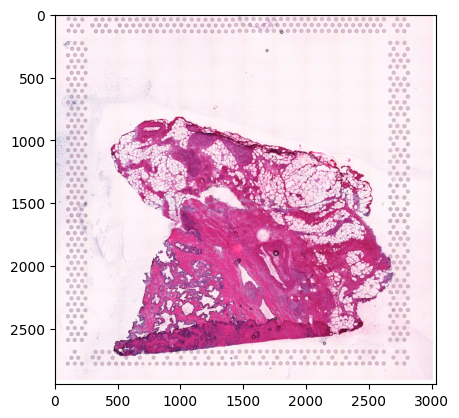

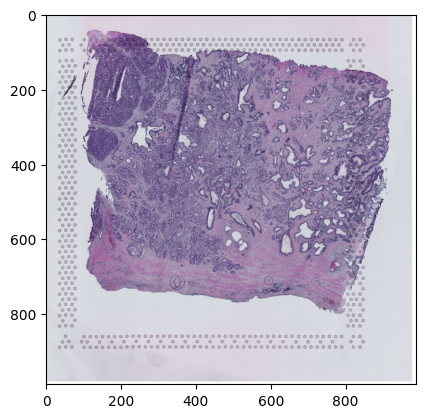

In [25]:
plt.imshow(next(iter(sdata_patient1_visium["H1_1_patient1_visium"]["scale4"].values())).transpose("y", "x", "c"))
plt.show()
plt.imshow(next(iter(sdata_patient1_visium["H1_4_patient1_visium"]["scale4"].values())).transpose("y", "x", "c"))
plt.show()

## Adding the expression data

The 1k expression data doesn't come in standard format, so we need to parse it manually. The same is true for the Visium expression data; in fact for this dataset the data doesn't follow the standard output structure of SpaceRanger, so we can't use `spatialdata-io` for reading it. Also, the Visium data requires some ad-hoc adjustment to the coordiantes and the table annotations.

### Adding the Visium expression data

Let's start with Visium data and let's make a simple function to parse it.

In [26]:
def parse_visium_data(suffix: str, folder: str, excluded_images: set[str]) -> SpatialData:
    sdatas = []
    for name in os.listdir(folder):
        if name in excluded_images:
            continue
        DATASET_PATH = os.path.join(folder, name)

        COUNTS_MATRIX_PATH = os.path.join(DATASET_PATH, "filtered_feature_bc_matrix.h5")
        SCALE_FACTOR_JSON_PATH = os.path.join(DATASET_PATH, "scalefactors_json.json")
        TISSUE_POSITIONS_PATH = os.path.join(DATASET_PATH, "tissue_positions_list.csv")
        ANNOTATIONS_PATH = os.path.join(DATASET_PATH, f"{name}_Final_Consensus_Annotations.csv")

        assert os.path.isfile(COUNTS_MATRIX_PATH)
        assert os.path.isfile(SCALE_FACTOR_JSON_PATH)
        assert os.path.isfile(TISSUE_POSITIONS_PATH)

        # expression data
        region = f"{name}{suffix}_shapes"
        adata = _read_10x_h5(COUNTS_MATRIX_PATH)
        adata.obs["instance_id"] = adata.obs_names
        adata.obs["region"] = region
        adata.obs["region"] = adata.obs["region"].astype("category")
        table = TableModel.parse(adata, region=region, region_key="region", instance_key="instance_id")
        table.var_names_make_unique()

        # scale factors
        with open(SCALE_FACTOR_JSON_PATH) as infile:
            scalefactors = json.load(infile)

        # circles coordinates
        df = pd.read_csv(TISSUE_POSITIONS_PATH, header=None, index_col=0)
        df = df[df.index.isin(adata.obs_names)]
        coords = df.iloc[:, np.array([4, 3])].values

        # if we don't remove the index name the writing to Zarr fails
        df.rename_axis(None, inplace=True)

        if suffix == "_patient1_visium":
            transformation = Identity()
        elif suffix == "_patient2_visium":
            # the coordinates for patient2_visium require an extra scaling by 0.5
            transformation = Scale([0.5, 0.5], axes=("x", "y"))
        else:
            raise ValueError(f"Unknown suffix: {suffix}")
        circles = ShapesModel.parse(
            coords,
            geometry=0,
            radius=scalefactors["spot_diameter_fullres"] / 2.0,
            index=df.index,
            transformations={f"{name}{suffix}": transformation},
        )

        # cell-type annotations, available only for patient 1
        if suffix == "_patient1_visium":
            assert os.path.isfile(ANNOTATIONS_PATH)
            annotations = pd.read_csv(ANNOTATIONS_PATH, index_col=0)
            annotations["Final_Annotations"] = annotations["Final_Annotations"].fillna("")
            annotations["Final_Annotations"] = annotations["Final_Annotations"].astype("str").astype("category")
            table.obs["Final_Annotations"] = annotations["Final_Annotations"]

        sdata = SpatialData(shapes={region: circles}, tables={"table": table})
        sdatas.append(sdata)
    c = concatenate(sdatas)
    return c

Not all the H&E images have associated expression, let's find out which one don't have it.

In [27]:
VISIUM_FOLDER_PATIENT1 = os.path.join(unzipped_path, "Count_matrices/Patient 1/Visium_with_annotation/")
VISIUM_FOLDER_PATIENT2 = os.path.join(unzipped_path, "Count_matrices/Patient_2/")

excluded_patient1 = set(os.listdir(VISIUM_FOLDER_PATIENT1)).symmetric_difference(
    {name.replace("_patient1_visium", "") for name in sdata_patient1_visium.images.keys()}
)
excluded_patient2 = set(os.listdir(VISIUM_FOLDER_PATIENT2)).symmetric_difference(
    {name.replace("_patient2_visium", "") for name in sdata_patient2_visium.images.keys()}
)

print(excluded_patient1)
print(excluded_patient2)

{'layout', 'V1_1', 'H1_1'}
{'V2_3', 'V2_6', 'H1_4', 'H1_2', 'H1_1', 'H2_3', 'H2_5', 'H3_3', 'H2_4', 'V2_5', 'H2_6', 'layout', 'H1_3', 'V2_4'}


In [28]:
if not EXPRESSION_ALREADY_CONVERTED:
    sdata_patient1_visium_expression = parse_visium_data(
        suffix="_patient1_visium", folder=VISIUM_FOLDER_PATIENT1, excluded_images=excluded_patient1
    )

    sdata_patient2_visium_expression = parse_visium_data(
        suffix="_patient2_visium", folder=VISIUM_FOLDER_PATIENT2, excluded_images=excluded_patient2
    )

INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient                                                
         1/Visium_with_annotation/H2_2/filtered_feature_bc_matrix.h5                                               
INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient                                                
         1/Visium_with_annotation/H1_2/filtered_feature_bc_matrix.h5                                               


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient                                                
         1/Visium_with_annotation/H2_1/filtered_feature_bc_matrix.h5                                               


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient                                                
         1/Visium_with_annotation/H2_5/filtered_feature_bc_matrix.h5                                               


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient                                                
         1/Visium_with_annotation/H1_4/filtered_feature_bc_matrix.h5                                               


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient                                                
         1/Visium_with_annotation/H1_5/filtered_feature_bc_matrix.h5                                               


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient                                                
         1/Visium_with_annotation/V1_2/filtered_feature_bc_matrix.h5                                               


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/V2_1/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/H2_2/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/H3_4/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/V2_2/filtered_feature_bc_matrix.h5           
INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/H3_6/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/V1_3/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/V1_6/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/H2_1/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/H3_1/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/V1_5/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/H3_2/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/V1_4/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/V1_2/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/V1_1/filtered_feature_bc_matrix.h5           
INFO     reading data/lundeberg/svw96g68dv-1/Count_matrices/Patient_2/H3_5/filtered_feature_bc_matrix.h5           


/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


We obtained new `SpatialData` objects, let's place the expression data in the ones that we previously constructed.

In [37]:
if not EXPRESSION_ALREADY_CONVERTED:
    # workaround for this https://github.com/scverse/spatialdata/issues/221, we will fix and remove this line
    sdata_patient1_visium_expression["table"].obs["region"] = (
        sdata_patient1_visium_expression["table"].obs["region"].astype("category")
    )
    sdata_patient1_visium_expression["table"].obs["Final_Annotations"] = (
        sdata_patient1_visium_expression["table"].obs["Final_Annotations"].astype("category")
    )
    sdata_patient2_visium_expression["table"].obs["region"] = (
        sdata_patient2_visium_expression["table"].obs["region"].astype("category")
    )

In [38]:
if not EXPRESSION_ALREADY_CONVERTED:
    for k, v in sdata_patient1_visium_expression.shapes.items():
        sdata_patient1_visium.add_shapes(name=k, shapes=v, overwrite=True)
        if "table" in sdata_patient1_visium.tables:
            del sdata_patient1_visium.tables["table"]
        sdata_patient1_visium["table"] = sdata_patient1_visium_expression["table"]

In [39]:
if not EXPRESSION_ALREADY_CONVERTED:
    for k, v in sdata_patient2_visium_expression.shapes.items():
        sdata_patient2_visium.add_shapes(name=k, shapes=v, overwrite=True)
        if "table" in sdata_patient2_visium.tables:
            del sdata_patient2_visium.tables["table"]
        sdata_patient2_visium["table"] = sdata_patient2_visium_expression["table"]

### Adding the 1k expressiond data (`patient1_1k`)

In [40]:
if not EXPRESSION_ALREADY_CONVERTED:
    ONE_K_FOLDER_PATIENT1 = os.path.join(unzipped_path, "Count_matrices/Patient 1/1k_arrays/")
    suffix = "_patient1_1k"
    sdatas = []
    for name in tqdm(os.listdir(ONE_K_FOLDER_PATIENT1)):
        DATASET_PATH = os.path.join(ONE_K_FOLDER_PATIENT1, name)
        files = os.listdir(DATASET_PATH)
        assert len(files) == 2
        expression_data_file = [f for f in files if f.endswith("_stdata.tsv")][0]
        positions_file = [f for f in files if not f.endswith("_stdata.tsv")][0]

        expression = pd.read_csv(os.path.join(DATASET_PATH, expression_data_file), sep="\t", index_col=0)
        positions = pd.read_csv(os.path.join(DATASET_PATH, positions_file), sep="\t", index_col=None)
        positions["instance_id"] = positions[["x", "y"]].apply(lambda x: f"{x['x']}x{x['y']}", axis=1)
        merged = pd.merge(positions, expression, left_on="instance_id", right_index=True, how="inner")
        positions_filtered = merged[positions.columns].copy()
        expression_filtered = merged[expression.columns].copy()

        adata = AnnData(expression_filtered, dtype=expression_filtered.values.dtype)
        adata.obs["instance_id"] = positions_filtered["instance_id"].to_numpy()
        assert adata.obs["instance_id"].is_unique

        region = f"{name}{suffix}_shapes"
        adata.obs["region"] = region
        adata.obs["region"] = adata.obs["region"].astype("category")

        table = TableModel.parse(adata, region=region, region_key="region", instance_key="instance_id")
        table.var_names_make_unique()

        coords = positions_filtered[["pixel_x", "pixel_y"]].values
        circles = ShapesModel.parse(
            coords,
            geometry=0,
            radius=50.0,  # standard radius in micrometers of 1k data
            index=adata.obs["instance_id"],
            transformations={f"{name}{suffix}": Identity()},
        )
        sdata = SpatialData(shapes={region: circles}, table=table)
        sdatas.append(sdata)
    sdata_patient1_1k_expression = concatenate(sdatas)

  0%|          | 0/21 [00:00<?, ?it/s]/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
  5%|▍         | 1/21 [00:07<02:23,  7.17s/it]/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 10%|▉         | 2/21 [00:14<02:17,  7.23s/it]/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 14%|█▍        | 3/21 [00:21<02:06,  7.05s/it]/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.

The 1k expression data is in a new `SpatialData` object, let's place the data in the `SpatialData` object that we constructed previously.

In [41]:
if not EXPRESSION_ALREADY_CONVERTED:
    sdata_patient1_1k_expression["table"].obs["region"] = (
        sdata_patient1_1k_expression["table"].obs["region"].astype("category")
    )

In [42]:
if not EXPRESSION_ALREADY_CONVERTED:
    for k, v in tqdm(sdata_patient1_1k_expression.shapes.items()):
        sdata_patient1_1k.add_shapes(name=k, shapes=v, overwrite=True)
        if "table" in sdata_patient1_1k.tables:
            del sdata_patient1_1k.tables["table"]
        sdata_patient1_1k["table"] = sdata_patient1_1k_expression["table"]

100%|██████████| 21/21 [00:30<00:00,  1.45s/it]


### Final comments

Let's look at the `SpatialData` objects that we constructed so far.

Let's reload the data from disk (for the case in which we skipped the cells above)

In [43]:
sdata_patient1_visium = SpatialData.read(SDATA_PATIENT1_VISIUM_PATH)
sdata_patient2_visium = SpatialData.read(SDATA_PATIENT2_VISIUM_PATH)
sdata_patient1_1k = SpatialData.read(SDATA_PATIENT1_1K_PATH)

/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/data/l989o/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Let's see the content of the `SpatialData` objects so far.

In [44]:
sdata_patient1_visium

SpatialData object with:
├── Images
│     ├── 'H1_1_patient1_visium': MultiscaleSpatialImage[cyx] (3, 47104, 48640), (3, 23552, 24320), (3, 11776, 12160), (3, 5888, 6080), (3, 2944, 3040)
│     ├── 'H1_2_patient1_visium': MultiscaleSpatialImage[cyx] (3, 13184, 13184), (3, 6592, 6592), (3, 3296, 3296), (3, 1648, 1648), (3, 824, 824)
│     ├── 'H1_4_patient1_visium': MultiscaleSpatialImage[cyx] (3, 15821, 15821), (3, 7910, 7910), (3, 3955, 3955), (3, 1977, 1977), (3, 988, 988)
│     ├── 'H1_5_patient1_visium': MultiscaleSpatialImage[cyx] (3, 13184, 13184), (3, 6592, 6592), (3, 3296, 3296), (3, 1648, 1648), (3, 824, 824)
│     ├── 'H2_1_patient1_visium': MultiscaleSpatialImage[cyx] (3, 15821, 15821), (3, 7910, 7910), (3, 3955, 3955), (3, 1977, 1977), (3, 988, 988)
│     ├── 'H2_2_patient1_visium': MultiscaleSpatialImage[cyx] (3, 15667, 15821), (3, 7833, 7910), (3, 3916, 3955), (3, 1958, 1977), (3, 979, 988)
│     ├── 'H2_5_patient1_visium': MultiscaleSpatialImage[cyx] (3, 15821, 15821), (

In [45]:
sdata_patient2_visium

SpatialData object with:
├── Images
│     ├── 'H1_1_patient2_visium': MultiscaleSpatialImage[cyx] (3, 24258, 24000), (3, 12129, 12000), (3, 6064, 6000), (3, 3032, 3000), (3, 1516, 1500)
│     ├── 'H1_2_patient2_visium': MultiscaleSpatialImage[cyx] (3, 24258, 24000), (3, 12129, 12000), (3, 6064, 6000), (3, 3032, 3000), (3, 1516, 1500)
│     ├── 'H1_3_patient2_visium': MultiscaleSpatialImage[cyx] (3, 24258, 24000), (3, 12129, 12000), (3, 6064, 6000), (3, 3032, 3000), (3, 1516, 1500)
│     ├── 'H1_4_patient2_visium': MultiscaleSpatialImage[cyx] (3, 24258, 24000), (3, 12129, 12000), (3, 6064, 6000), (3, 3032, 3000), (3, 1516, 1500)
│     ├── 'H2_1_patient2_visium': MultiscaleSpatialImage[cyx] (3, 21221, 24000), (3, 10610, 12000), (3, 5305, 6000), (3, 2652, 3000), (3, 1326, 1500)
│     ├── 'H2_2_patient2_visium': MultiscaleSpatialImage[cyx] (3, 23242, 24000), (3, 11621, 12000), (3, 5810, 6000), (3, 2905, 3000), (3, 1452, 1500)
│     ├── 'H2_3_patient2_visium': MultiscaleSpatialImage[cyx] (3

In [46]:
sdata_patient1_1k

SpatialData object with:
├── Images
│     ├── 'H1_1_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H1_2_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H1_3_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H1_4_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H1_5_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H2_1_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H2_2_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 

<img src="attachments/lundeberg_gene_expression.png" width="50%">
<img src="attachments/lundeberg_cell_types.png" width="50%">

## Spatially aligning the data

### Aligning the 1k expression data to the corresponding images

As we can see, the 1k images and the expression data are not aligned.

Also, after manual inspection, it seems that the best alignemnt for one sample, if used for another sample, may map the shapes onto the image suboptimally. Therefore we will recompute the alignment for all the samples.

<img src="attachments/1k_not_aligned.png" width="50%">

For each 1k sample we want to find a transformation that maps the expression to the image. To do this we will automatically identify some landmark points in each expression and image and compute the similarity affine transformation that aligns them.

We will use perform some image processing functions to identify the bounding box of each image, and we will use the corners of the bounding box as landmark points. We will then compute the bounding box also for the expression location.

In [47]:
import numpy as np
import skimage.color
import skimage.filters
import skimage.io
import skimage.morphology
from scipy.ndimage import binary_fill_holes, label
from skimage.measure import regionprops


def segment_tissue(image):
    # Convert the image to grayscale
    gray_image = skimage.color.rgb2gray(image)

    # Apply a Gaussian blur to reduce noise
    blurred_image = skimage.filters.gaussian(gray_image, sigma=1)

    # Threshold the image to create a binary mask
    threshold = skimage.filters.threshold_otsu(blurred_image)
    binary_mask = blurred_image < threshold

    # Apply morphological operations to refine the mask
    # The parameters have been found with a few trial and errors so that it works for our data
    kernel = skimage.morphology.square(3)
    opening = skimage.morphology.opening(binary_mask, footprint=kernel)
    kernel = skimage.morphology.square(20)
    sure_bg = skimage.morphology.dilation(opening, footprint=kernel)

    return sure_bg

In [48]:
from spatialdata.models import PointsModel

H1_1_patient1_1k


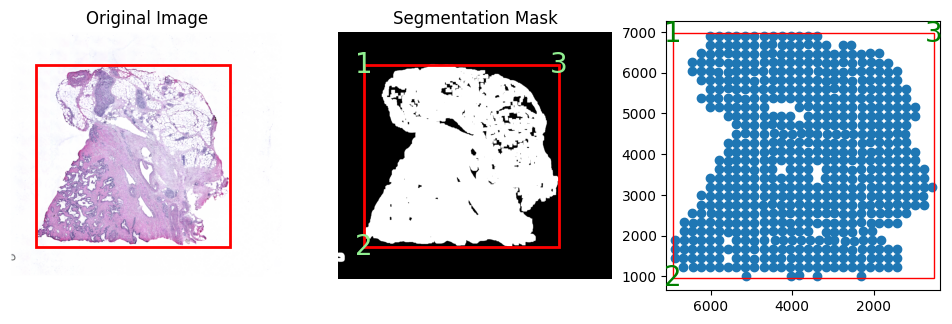

H1_2_patient1_1k


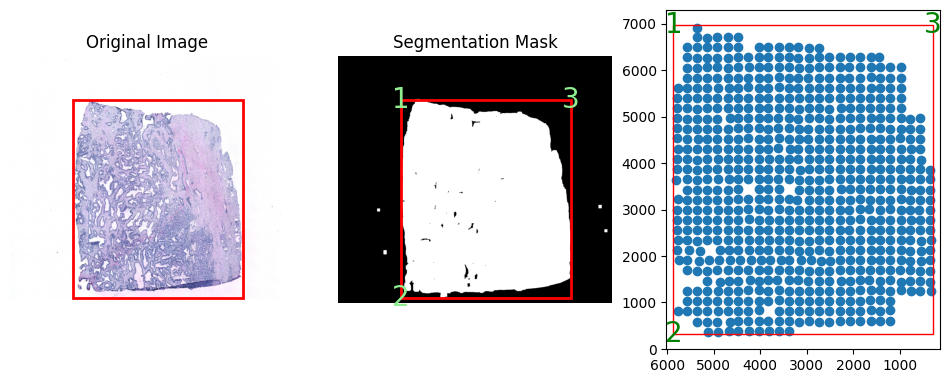

H1_3_patient1_1k


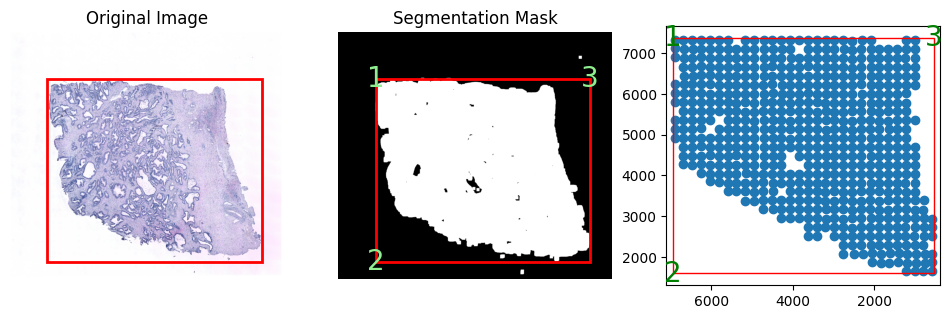

H1_4_patient1_1k


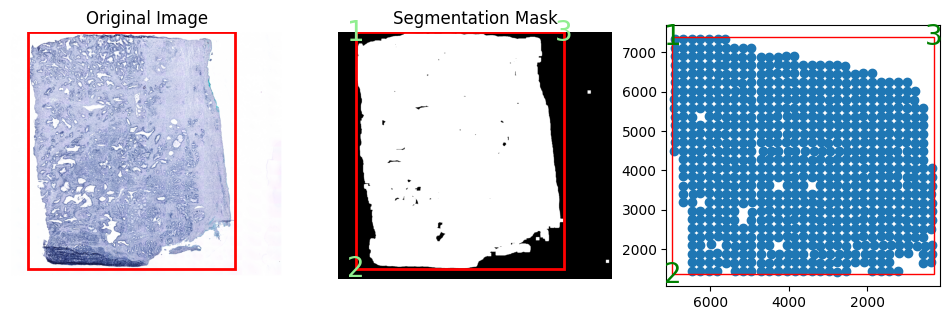

H1_5_patient1_1k


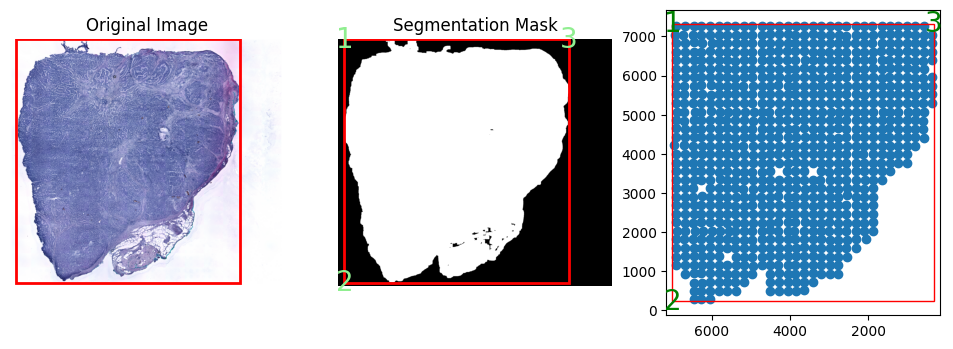

H2_1_patient1_1k


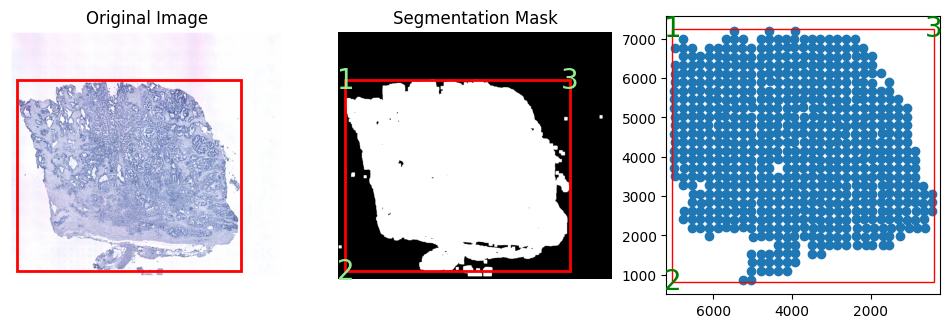

H2_2_patient1_1k


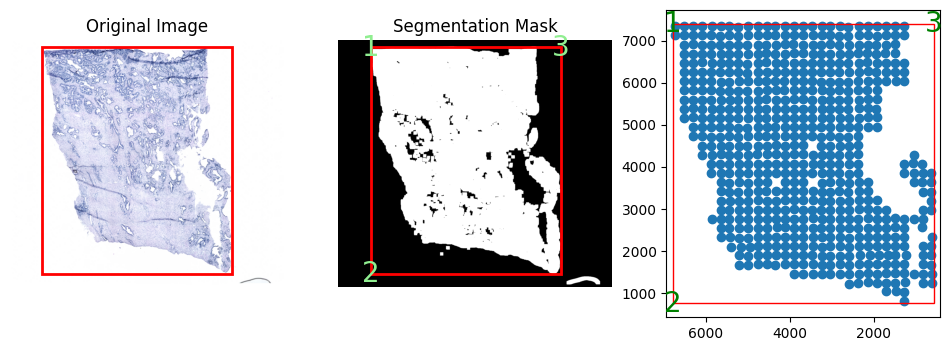

H2_3_patient1_1k


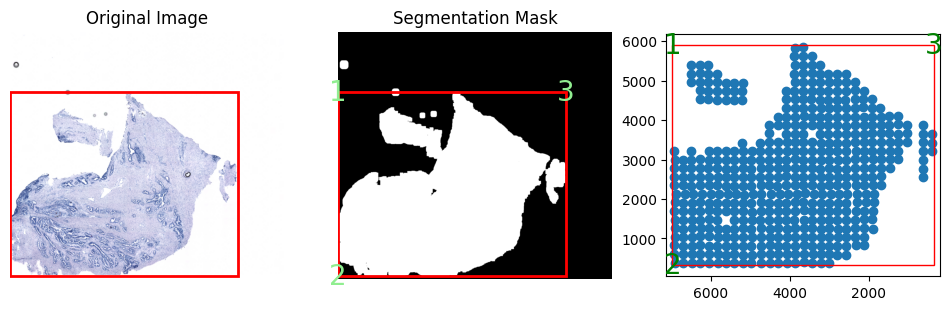

H2_4_patient1_1k


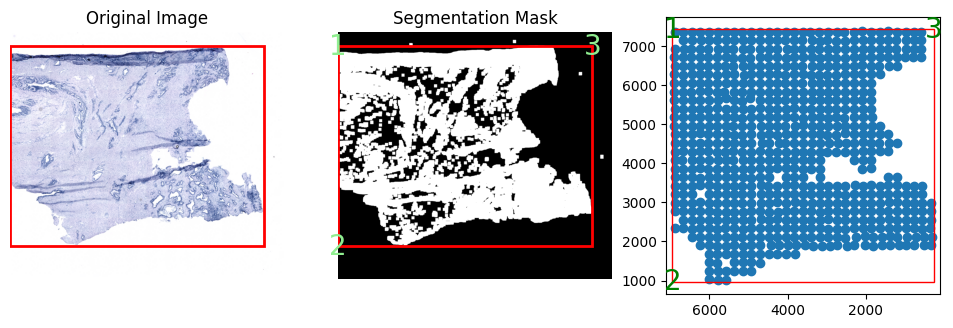

H2_5_patient1_1k


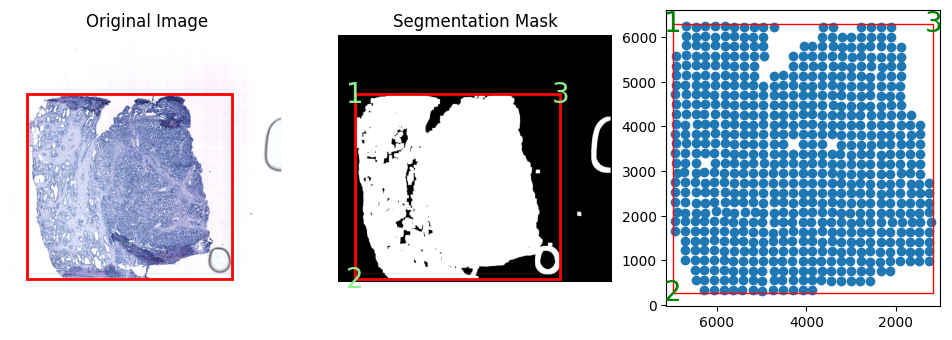

V1_1_patient1_1k


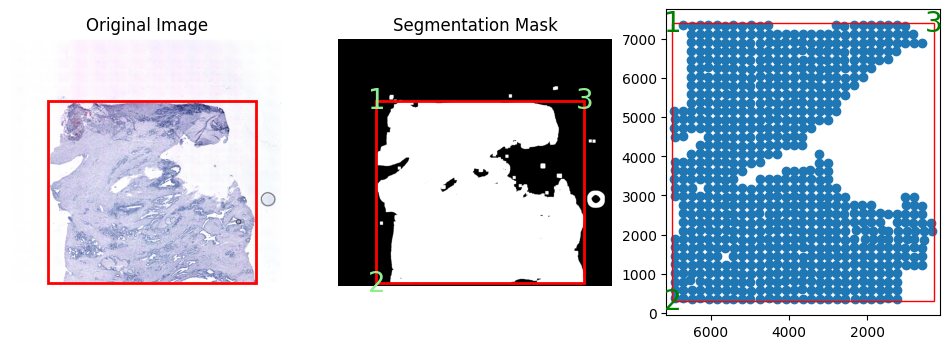

V1_2_patient1_1k


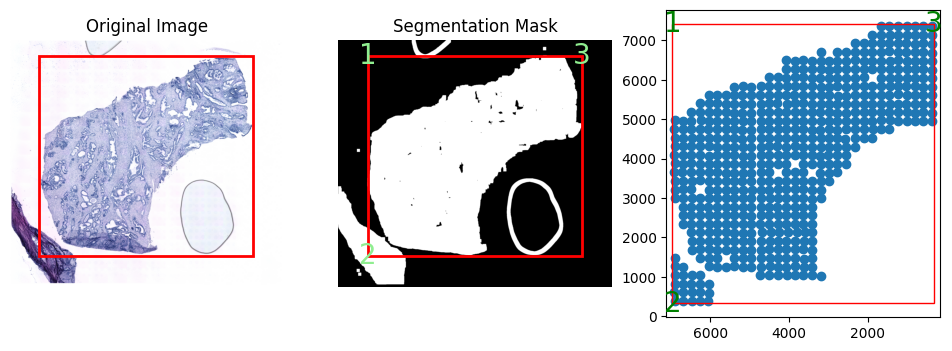

V1_3_patient1_1k


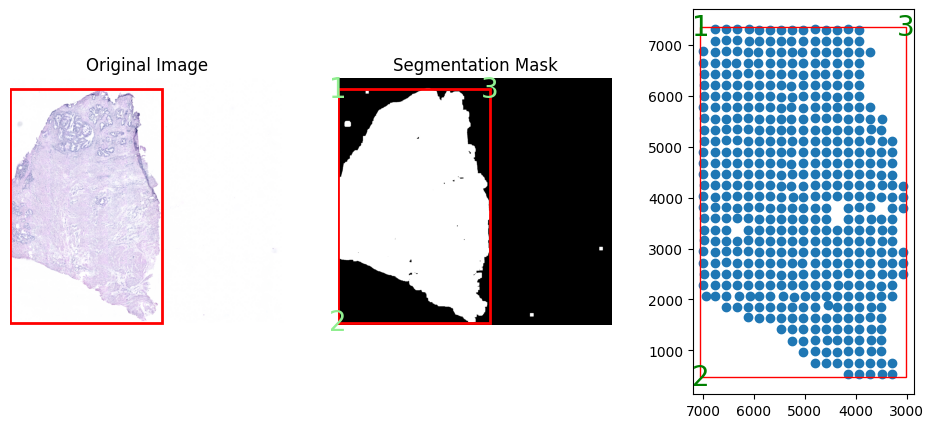

V1_4_patient1_1k


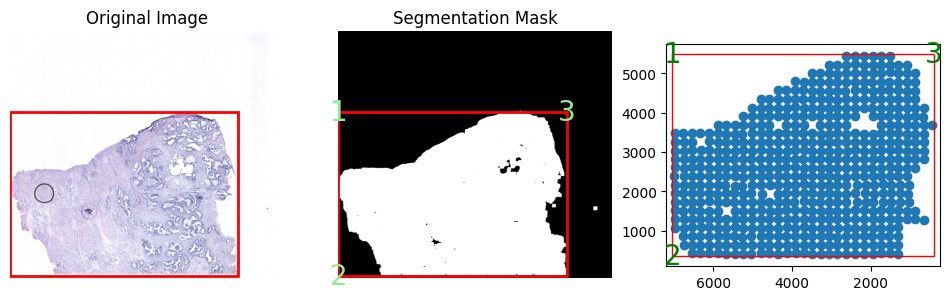

V1_5_patient1_1k


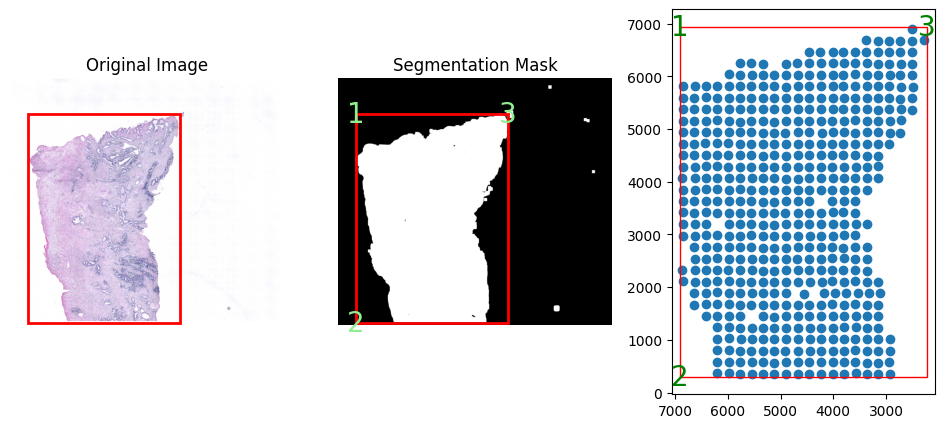

V2_1_patient1_1k


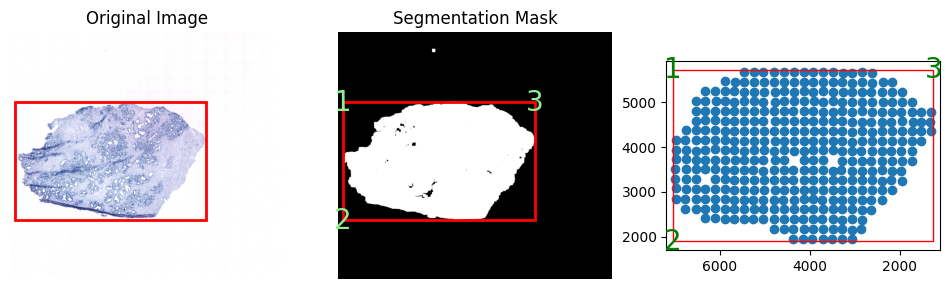

V2_2_patient1_1k


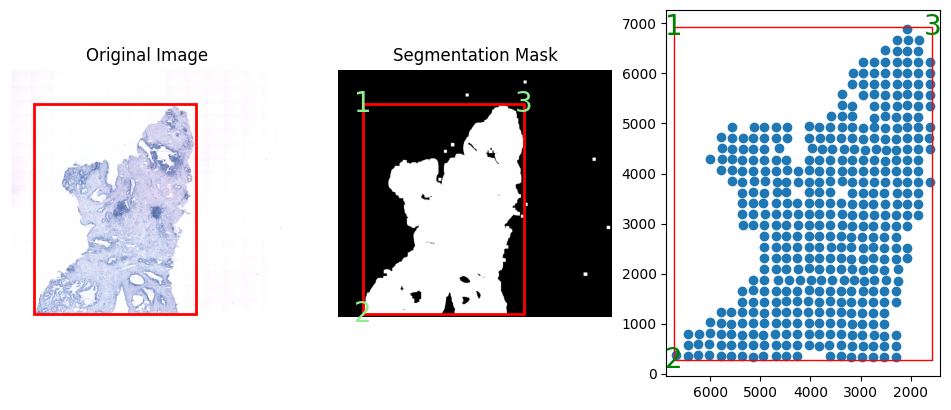

V2_3_patient1_1k


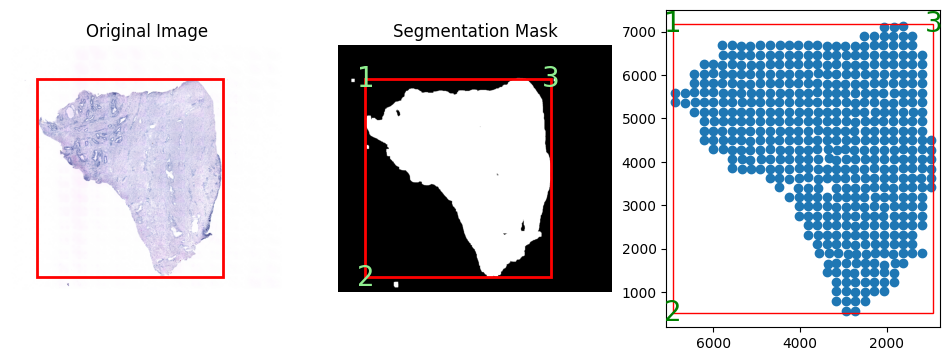

V2_4_patient1_1k


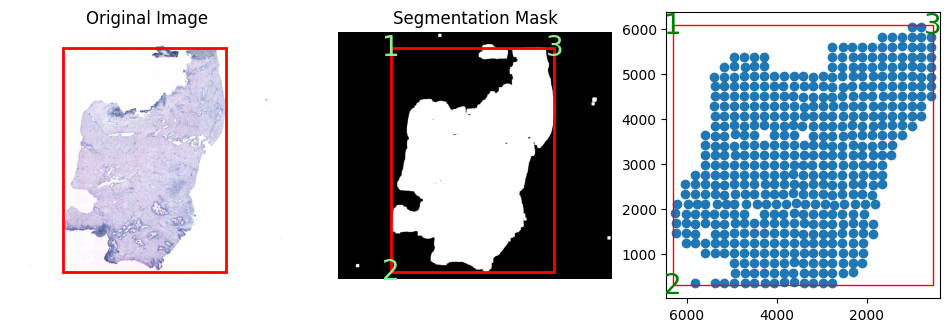

V2_5_patient1_1k


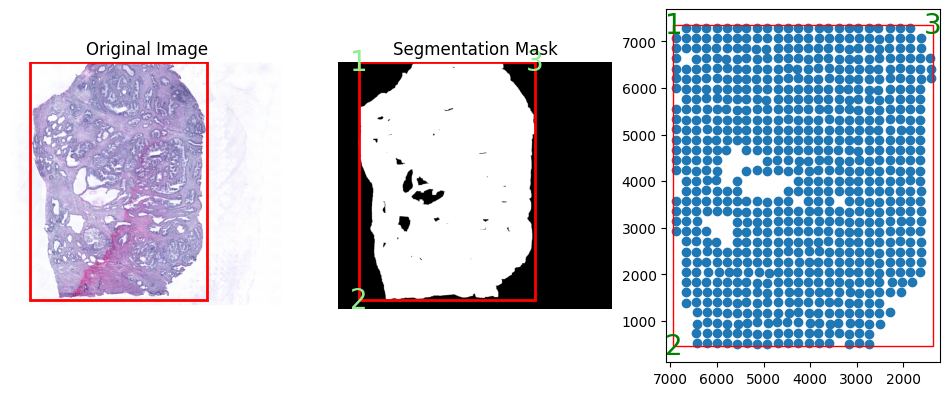

V2_6_patient1_1k


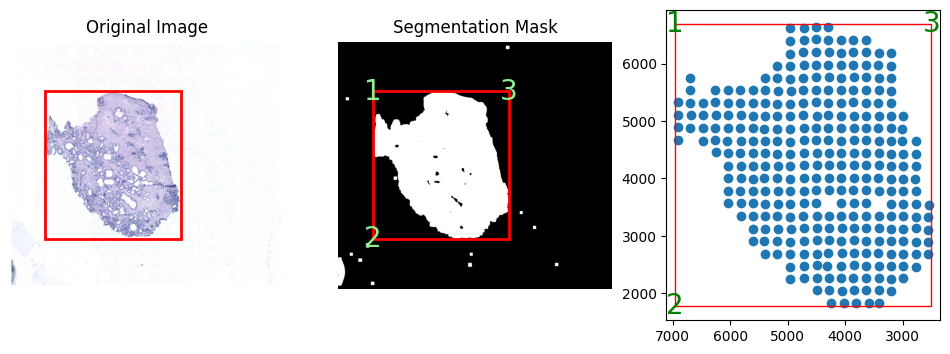

In [49]:
import matplotlib.patches as patches

landmarks_images = {}
landmarks_expression = {}

for element_name in sdata_patient1_1k.shapes.keys():
    # find the landmark points for the image
    name = element_name.replace("_shapes", "")
    print(name)
    shapes = sdata_patient1_1k[element_name]
    img = sdata_patient1_1k[name]
    img_small = img["scale4"].transpose("y", "x", "c").values().__iter__().__next__()
    # scale transformation of the multiscale image
    scale_yx = (
        get_transformation(SpatialImage(img_small), to_coordinate_system=name)
        .transformations[0]
        .to_scale_vector(axes=("y", "x"))
    )
    x = img_small.compute().data
    mask = segment_tissue(x)
    filled_mask = binary_fill_holes(mask)

    # Find connected components in the binary mask
    labeled_mask, num_components = label(filled_mask)

    # Compute region properties for connected components
    regions = regionprops(labeled_mask)

    # Find the main connected component (the one with the largest area)
    main_component = max(regions, key=lambda x: x.area)

    # Get the bounding box of the main connected component
    bbox = main_component.bbox
    # print("Bounding box:", bbox)

    # Bounding box format: (min_row, min_col, max_row, max_col)
    min_row, min_col, max_row, max_col = bbox

    # find the landmark points for the expression data
    radius = shapes.radius.iloc[0]
    minx, miny, _, _ = (shapes.geometry.bounds.min(axis=0) - radius).tolist()
    _, _, maxx, maxy = (shapes.geometry.bounds.max(axis=0) + radius).tolist()

    landmarks_images[name] = PointsModel.parse(
        scale_yx * np.array([[min_col, min_row], [min_col, max_row], [max_col, min_row]])
    )

    landmarks_expression[name] = PointsModel.parse(np.array([[maxx, maxy], [maxx, miny], [minx, maxy]]))

    # visualize
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    axes[0].imshow(x, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    rect = patches.Rectangle(
        (min_col, min_row), max_col - min_col, max_row - min_row, linewidth=2, edgecolor="r", facecolor="none"
    )
    axes[0].add_patch(rect)

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")
    rect = patches.Rectangle(
        (min_col, min_row), max_col - min_col, max_row - min_row, linewidth=2, edgecolor="r", facecolor="none"
    )
    axes[1].add_patch(rect)

    # show the landmark points
    for i, row in landmarks_images[name].compute().iterrows():
        axes[1].text(
            row["x"] / scale_yx[1],
            row["y"] / scale_yx[0],
            str(i + 1),
            fontsize=20,
            color="lightgreen",
            ha="center",
            va="center",
        )

    axes[2].scatter(shapes.geometry.x, shapes.geometry.y)
    axes[2].set_aspect("equal")
    rect = patches.Rectangle((minx, miny), maxx - minx, maxy - miny, linewidth=1, edgecolor="r", facecolor="none")
    axes[2].add_patch(rect)
    # show the landmark points
    for i, row in landmarks_expression[name].compute().iterrows():
        axes[2].text(row["x"], row["y"], str(i + 1), fontsize=20, color="green", ha="center", va="center")

    # reverse the x axis
    axes[2].set_xlim(maxx + 150, minx - 150)
    plt.show()

From the above we notice that the alignemnt of `H1_4_patient1_1k` seems wrong, or at least non-obvious. Let's remove it from the dataset to avoid errors downstreams.

Note: for the sake of the reproducibility of this notebook, in the following we will remove elements or adjust transformations, only in-memory. The user can always save the changes on-disk at the end of the notebook.

In [50]:
if "H1_4_patient1_1k" in sdata_patient1_1k.images:
    del sdata_patient1_1k.images["H1_4_patient1_1k"]
if "H1_4_patient1_1k_shapes" in sdata_patient1_1k.shapes:
    del sdata_patient1_1k.shapes["H1_4_patient1_1k_shapes"]

In [51]:
from spatialdata.transformations import align_elements_using_landmarks

for element_name in sdata_patient1_1k.shapes.keys():
    name = element_name.replace("_shapes", "")
    if name == "H1_4_patient1_1k":
        continue
    align_elements_using_landmarks(
        references_coords=landmarks_images[name],
        moving_coords=landmarks_expression[name],
        reference_element=sdata_patient1_1k[name],
        moving_element=sdata_patient1_1k[element_name],
        reference_coordinate_system=name,
        moving_coordinate_system=name,
        new_coordinate_system=name,
        write_to_sdata=None,
    )

As we can see using `napari-spatialdata`, the alignment can still be improved. We will refine it by manually annotating landmark points and then re-computing a similarity transformation that aligns the data.

The landmark points that you will find hardcoded in this notebook have been manually annotated, and sometimes two rounds of alignments have been used (first an approximate alignment and then a fine one). In order to perform this task without error we have written a simple function that, for each image at the time, prepare a `SpatialData` object with just the elements to align, and prepare already created the elemnts to contain the source and target landmarks.

Note: since the landmarks are now all found, this function will not be executed in the notebook, therefore it may break and require small adjustments if you need to use it in the future. If you notice this, please report a bug.

In [52]:
def bulk_landmarks_annotation(sdata, suffix, show_layout: bool, show_shapes: bool):
    layout_image = sdata[f"layout_{suffix}"]

    # empty shapes are actually not currently supported, so let's add one
    one_point = np.array([[10, 0]])

    for element_name in sdata.shapes.keys():
        name = element_name.replace("_shapes", "")
        # use this if else logic if you want to refine the alignment for particular instances
        # if name not in ['H1_2_patient1_visium']:
        # continue
        points_element = PointsModel.parse(one_point, transformations={name: Identity()})
        images = {name: sdata.images[name]}
        if show_layout:
            images["layout_image"] = layout_image
        merged = SpatialData(images)
        merged.add_points(name=name + "_shapes_source", points=points_element.copy())
        merged.add_points(name=name + "_shapes_target", points=points_element.copy())
        if show_shapes:
            merged.add_shapes(name=element_name, shapes=sdata[element_name])
            merged["table"] = sdata["table"]
        Interactive(merged)
        landmarks = SpatialData(points=merged.points)
        # remove the first coordinate pair coming from "empty_shapes"
        keys = list(landmarks.points.keys())
        for k in keys:
            v = landmarks.points[k]
            new_v = v.compute().iloc[1:]
            print(k)
            print(new_v)
            print()


# uncomment to manually add new landmark points
# bulk_landmarks_annotation(sdata=sdata_patient1_1k, suffix='patient1_1k', show_layout=False, show_shapes=True)

Now, for each image we will manually review the alignment, comment it and improve it by using the landmarks approach whenever possible.

**Note:** please keep in mind that this notebook is to showcase a real-world scenario of using the `spatialdata` library with a complex dataset; the alignments are rated by visual agreement between the spatial elements but have not been reviewed with the context of their underlying biology.

In [53]:
# expression (moving)
landmarks_source = {}
# image (reference)
landmarks_target = {}

# H1_1_patient1_1k: the alignment is improved by using these landmarks
landmarks_source["H1_1_patient1_1k"] = PointsModel.parse(
    np.array(
        [
            [4504, 6704],
            [6110, 3842],
            [13105, 3683],
            [24233, 10376],
            [25601, 17054],
            [20625, 20742],
            [22516, 24224],
            [13073, 24701],
            [2978, 23540],
            [8319, 11696],
            [13216, 10360],
        ]
    )
)

landmarks_target["H1_1_patient1_1k"] = PointsModel.parse(
    np.array(
        [
            [5092, 7387],
            [6618, 4701],
            [12993, 4160],
            [24027, 10472],
            [25362, 17658],
            [20736, 20694],
            [22675, 24065],
            [13057, 24271],
            [3296, 23635],
            [8987, 11807],
            [13359, 10663],
        ]
    )
)

# H1_2_patient1_1k: the alignment is good enough

# H1_3_patient1_1k: the alignment is suboptimal. It could be improved but it's difficult to find landmarks

# H1_5_patient1_1k: the alignment seems to be improved by using these landmarks
landmarks_source["H1_5_patient1_1k"] = PointsModel.parse(np.array([[7270, 281], [3566, 28055], [17636, 24081]]))

landmarks_target["H1_5_patient1_1k"] = PointsModel.parse(np.array([[7413, 1203], [6316, 27864], [18780, 24081]]))

# H2_1_patient1_1k: the alignment is improved by using these landmarks
landmarks_source["H2_1_patient1_1k"] = PointsModel.parse(
    np.array(
        [
            [1769, 6163],
            [11801, 5877],
            [23582, 14987],
            [25521, 22713],
            [22787, 24573],
            [8065, 28166],
            [10656, 25241],
            [3025, 24049],
            [1515, 16449],
        ]
    )
)

landmarks_target["H2_1_patient1_1k"] = PointsModel.parse(
    np.array(
        [
            [1054, 7912],
            [11865, 6465],
            [25028, 15273],
            [26316, 23540],
            [23454, 24844],
            [9798, 27530],
            [11737, 24860],
            [5362, 23492],
            [3836, 16306],
        ]
    )
)

# H2_2_patient1_1k: the alignment is improved by using these landmarks
landmarks_source["H2_2_patient1_1k"] = PointsModel.parse(
    np.array([[3184, 1489], [23947, 1028], [24424, 12618], [26777, 16863], [9448, 23047]])
)

landmarks_target["H2_2_patient1_1k"] = PointsModel.parse(
    np.array([[3995, 1394], [22898, 1108], [22389, 13747], [25044, 17880], [9909, 23413]])
)

# H2_3_patient1_1k: the alignment is improved by using these landmarks
landmarks_source["H2_3_patient1_1k"] = PointsModel.parse(
    np.array([[1912, 8707], [7206, 12316], [12135, 6974], [24901, 14796], [25028, 20186], [15648, 28516], [164, 28373]])
)

landmarks_target["H2_3_patient1_1k"] = PointsModel.parse(
    np.array(
        [[5267, 9629], [10005, 13159], [13582, 7229], [24997, 14828], [25140, 19947], [13598, 28103], [195, 28198]]
    )
)

# H2_4_patient1_1k: the alignment is improved by using these landmarks
landmarks_source["H2_4_patient1_1k"] = PointsModel.parse(
    np.array(
        [
            [1420, 392],
            [12453, 1044],
            [27047, 1728],
            [26793, 4717],
            [21435, 8437],
            [23915, 13143],
            [15839, 15273],
            [27079, 23874],
            [3709, 26338],
            [2532, 21346],
        ]
    )
)

landmarks_target["H2_4_patient1_1k"] = PointsModel.parse(
    np.array(
        [
            [386, 2729],
            [11944, 2809],
            [24949, 2109],
            [25235, 5718],
            [20593, 8818],
            [23136, 12872],
            [16348, 15305],
            [29225, 20901],
            [6841, 24637],
            [3025, 19200],
        ]
    )
)

# H2_5_patient1_1k: the alignment is improved by using these landmarks
landmarks_source["H2_5_patient1_1k"] = PointsModel.parse(
    np.array(
        [
            [3566, 7769],
            [11722, 6672],
            [10116, 11616],
            [15251, 7022],
            [21499, 7101],
            [23470, 15384],
            [24043, 26910],
            [4393, 29041],
            [2501, 18659],
        ]
    )
)

landmarks_target["H2_5_patient1_1k"] = PointsModel.parse(
    np.array(
        [
            [3439, 8596],
            [11531, 7737],
            [10084, 11744],
            [14567, 7594],
            [20211, 7594],
            [22278, 15543],
            [23216, 25162],
            [6125, 28278],
            [3073, 18071],
        ]
    )
)

# V1_1_patient1_1k: the alignment is suboptimal. It could be improved but it's difficult to find landmarks

# V1_2_patient1_1k: the alignment is slightly improved by using these landmarks
landmarks_source["V1_2_patient1_1k"] = PointsModel.parse(
    np.array(
        [
            [4090, 9597],
            [22580, 1887],
            [27286, 2014],
            [27127, 10631],
            [16825, 23890],
            [6412, 22825],
            [3661, 16513],
            [3582, 21680],
        ]
    )
)

landmarks_target["V1_2_patient1_1k"] = PointsModel.parse(
    np.array(
        [
            [4186, 10980],
            [23009, 2173],
            [26173, 2284],
            [27620, 10678],
            [16984, 24240],
            [6046, 23238],
            [3629, 16688],
            [3439, 22077],
        ]
    )
)

# V1_3_patient1_1k: the alignment is improved by using these landmarks
landmarks_source["V1_3_patient1_1k"] = PointsModel.parse(
    np.array([[13677, 28866], [6571, 25352], [259, 22316], [13645, 1330], [16586, 16147]])
)

landmarks_target["V1_3_patient1_1k"] = PointsModel.parse(
    np.array([[15426, 28357], [7683, 23572], [354, 20790], [14011, 1982], [17318, 15607]])
)

# V1_4_patient1_1k: the alignment is improved by using these landmarks, but it could be improved more
landmarks_source["V1_4_patient1_1k"] = PointsModel.parse(
    np.array([[370, 16497], [21117, 9359], [25935, 16418], [16094, 29009], [8590, 28882]])
)

landmarks_target["V1_4_patient1_1k"] = PointsModel.parse(
    np.array([[386, 16449], [21038, 9661], [25998, 16449], [19766, 28230], [11976, 28214]])
)

# V1_5_patient1_1k: the alignment is improved by using these landmarks
landmarks_source["V1_5_patient1_1k"] = PointsModel.parse(
    np.array([[2389, 8167], [19067, 4383], [14949, 17753], [16714, 28564], [4615, 28373], [2183, 21378]])
)

landmarks_target["V1_5_patient1_1k"] = PointsModel.parse(
    np.array([[3009, 8310], [19114, 4589], [15251, 17213], [17032, 28325], [6650, 28151], [4090, 20853]])
)

# V2_1_patient1_1k: the alignment is improved by using these landmarks
landmarks_source["V2_1_patient1_1k"] = PointsModel.parse(
    np.array([[815, 13858], [12040, 8135], [22548, 11950], [15664, 22236], [3248, 20488]])
)

landmarks_target["V2_1_patient1_1k"] = PointsModel.parse(
    np.array([[1054, 14510], [13168, 8516], [22580, 12475], [16968, 21489], [3598, 19772]])
)

# V2_2_patient1_1k: the alignment is good enough

# V2_3_patient1_1k: the alignment is good enough

# V2_4_patient1_1k: the alignment is improved by using these landmarks
landmarks_source["V2_4_patient1_1k"] = PointsModel.parse(
    np.array([[9861, 5925], [14854, 7165], [26364, 2189], [26920, 9518], [5823, 22157]])
)

landmarks_target["V2_4_patient1_1k"] = PointsModel.parse(
    np.array([[9782, 8151], [15060, 9248], [23788, 2093], [24742, 11108], [6571, 22904]])
)

# V2_5_patient1_1k: the alignment is improved by using these landmarks
landmarks_source["V2_5_patient1_1k"] = PointsModel.parse(
    np.array(
        [[9909, 13699], [7206, 11823], [2946, 13635], [4186, 26926], [18701, 26751], [22882, 20647], [23439, 4764]]
    )
)

landmarks_target["V2_5_patient1_1k"] = PointsModel.parse(
    np.array(
        [[10482, 15607], [8876, 13810], [4170, 14621], [5823, 27387], [18319, 26910], [22246, 20996], [22691, 7896]]
    )
)

# V2_6_patient1_1k: the alignment is slightly improved by using these landmarks
landmarks_source["V2_6_patient1_1k"] = PointsModel.parse(
    np.array([[4186, 12872], [4822, 8802], [17302, 7324], [19559, 19963], [13407, 22856], [7175, 16720]])
)

landmarks_target["V2_6_patient1_1k"] = PointsModel.parse(
    np.array([[4393, 13174], [4536, 8612], [16952, 7562], [19559, 19677], [13375, 22666], [7270, 16879]])
)

In [54]:
for name in landmarks_source.keys():
    align_elements_using_landmarks(
        references_coords=landmarks_target[name],
        moving_coords=landmarks_source[name],
        reference_element=sdata_patient1_1k[name],
        moving_element=sdata_patient1_1k[f"{name}_shapes"],
        reference_coordinate_system=name,
        moving_coordinate_system=name,
        # we use a new name to be able to compare the new alignment with the old one. When we are happy with the alignemnt, we overwrite the old one
        #        new_coordinate_system=name + '_aligned',
        new_coordinate_system=name,
        write_to_sdata=None,
    )

### Aligning the large images to the image layout (`patient1_1k`)

Let's align the large microscopy images to the schematic layout. We already aligned the spatial transcriptomics locations to the microscopy images, so we will transitively have the expression data aligned to the schematic layout.

The samples `H1_2_patient1_1k`, `H2_1_patient1_1k`, `H2_2_patient1_1k`, `H2_5_patient1_1k`, `V1_1_patient1_1k`, `V1_3_patient1_1k`, `V2_6_patient1_1k` appear to be be incorrectly represented in the layout, so we will not align them to the layout image.

In [55]:
# H&E images (moving)
landmarks_source = {}
# schematic layout (reference)
landmarks_target = {}

landmarks_source["H2_3_patient1_1k"] = PointsModel.parse(np.array([[13633, 7289], [24345, 14684], [1668, 27094]]))

landmarks_target["H2_3_patient1_1k"] = PointsModel.parse(np.array([[365, 331], [397, 386], [466, 274]]))

landmarks_source["V1_4_patient1_1k"] = PointsModel.parse(np.array([[574, 17007], [22093, 9853], [26236, 28125]]))

landmarks_target["V1_4_patient1_1k"] = PointsModel.parse(np.array([[498, 89], [603, 63], [607, 151]]))

landmarks_source["H1_1_patient1_1k"] = PointsModel.parse(np.array([[5382, 7448], [3223, 23476], [25313, 17334]]))

landmarks_target["H1_1_patient1_1k"] = PointsModel.parse(np.array([[225, 466], [302, 444], [288, 550]]))

landmarks_source["H1_3_patient1_1k"] = PointsModel.parse(np.array([[24313, 6480], [28931, 24539], [4810, 6258]]))

landmarks_target["H1_3_patient1_1k"] = PointsModel.parse(np.array([[467, 535], [560, 531], [445, 440]]))

landmarks_source["H1_5_patient1_1k"] = PointsModel.parse(np.array([[12443, 27490], [25329, 3211], [1859, 4830]]))

landmarks_target["H1_5_patient1_1k"] = PointsModel.parse(np.array([[727, 448], [768, 335], [678, 350]]))

landmarks_source["V2_4_patient1_1k"] = PointsModel.parse(np.array([[23949, 2112], [8469, 19541], [16934, 27493]]))

landmarks_target["V2_4_patient1_1k"] = PointsModel.parse(np.array([[402, 217], [483, 142], [521, 188]]))

landmarks_source["V1_2_patient1_1k"] = PointsModel.parse(np.array([[27614, 11018], [16902, 24205], [4144, 11034]]))

landmarks_target["V1_2_patient1_1k"] = PointsModel.parse(np.array([[306, 180], [372, 129], [300, 60]]))

landmarks_source["V1_5_patient1_1k"] = PointsModel.parse(
    np.array([[17029, 28204], [15427, 15747], [19362, 4496], [2763, 8702]])
)

landmarks_target["V1_5_patient1_1k"] = PointsModel.parse(np.array([[614, 122], [660, 143], [689, 188], [732, 121]]))

landmarks_source["V2_1_patient1_1k"] = PointsModel.parse(np.array([[22568, 12447], [16871, 21413], [3874, 13430]]))

landmarks_target["V2_1_patient1_1k"] = PointsModel.parse(np.array([[138, 280], [178, 254], [136, 196]]))

landmarks_source["V2_2_patient1_1k"] = PointsModel.parse(np.array([[19299, 28204], [19902, 4338], [6207, 12097]]))

landmarks_target["V2_2_patient1_1k"] = PointsModel.parse(np.array([[334, 259], [221, 256], [262, 187]]))

landmarks_source["V2_3_patient1_1k"] = PointsModel.parse(np.array([[17749, 26800], [21495, 4157], [3384, 8675]]))

landmarks_target["V2_3_patient1_1k"] = PointsModel.parse(np.array([[447, 247], [344, 278], [359, 192]]))

landmarks_source["V2_5_patient1_1k"] = PointsModel.parse(
    np.array([[18267, 26983], [5762, 27379], [2747, 5544], [9206, 243]])
)

landmarks_target["V2_5_patient1_1k"] = PointsModel.parse(np.array([[636, 234], [636, 171], [547, 159], [517, 182]]))

In [56]:
for name in landmarks_source.keys():
    affine = align_elements_using_landmarks(
        references_coords=landmarks_target[name],
        moving_coords=landmarks_source[name],
        reference_element=sdata_patient1_1k["layout_patient1_1k"],
        moving_element=sdata_patient1_1k[name],
        reference_coordinate_system="patient1_1k",
        moving_coordinate_system=name,
        new_coordinate_system="patient1_1k",
        write_to_sdata=None,
    )
    align_elements_using_landmarks(
        references_coords=landmarks_target[name],
        moving_coords=landmarks_source[name],
        reference_element=sdata_patient1_1k["layout_patient1_1k"],
        moving_element=sdata_patient1_1k[f"{name}_shapes"],
        reference_coordinate_system="patient1_1k",
        moving_coordinate_system=name,
        new_coordinate_system="patient1_1k",
        write_to_sdata=None,
    )

### Aligning the large images to the image layout (`patient1_visium`)

Let's align the samples to the layout schematic.

The samples `H1_1_patient1_visium`, `V1_1_patient1_visium` are not present in the schematic, so they will be skipped.

In [57]:
# H&E images (moving)
landmarks_source = {}
# schematic layout (reference)
landmarks_target = {}

landmarks_source["H1_2_patient1_visium"] = PointsModel.parse(
    np.array([[1943.391353, 5825.328589], [5263.469157, 11027.999961], [8481.390721, 6146.391058]])
)

landmarks_target["H1_2_patient1_visium"] = PointsModel.parse(
    np.array([[250.281495, 368.644963], [307.899398, 373.515244], [288.583367, 323.326583]])
)

landmarks_source["H1_4_patient1_visium"] = PointsModel.parse(
    np.array(
        [
            [1811.134891, 773.155582],
            [14627.487007, 2898.334513],
            [12574.839781, 12791.658954],
            [2152.033900, 11297.505849],
        ]
    )
)

landmarks_target["H1_4_patient1_visium"] = PointsModel.parse(
    np.array([[461.776505, 274.925141], [374.959757, 290.751708], [386.084228, 368.737690], [470.607270, 346.832804]])
)

landmarks_source["H1_5_patient1_visium"] = PointsModel.parse(
    np.array([[10641.265512, 2994.141363], [8671.109453, 12071.452985], [1505.578895, 2899.281997]])
)

landmarks_target["H1_5_patient1_visium"] = PointsModel.parse(
    np.array([[471.391952, 249.262097], [488.402955, 326.930754], [547.717636, 240.980425]])
)

landmarks_source["H2_1_patient1_visium"] = PointsModel.parse(
    np.array(
        [
            [3768.241789, 3706.947408],
            [6307.585962, 5081.695805],
            [11438.812463, 8032.588861],
            [2577.376936, 11000.994635],
        ]
    )
)

landmarks_target["H2_1_patient1_visium"] = PointsModel.parse(
    np.array([[22.147673, 283.191204], [31.911205, 261.730767], [46.798175, 224.320005], [76.572115, 286.574607]])
)

landmarks_source["H2_2_patient1_visium"] = PointsModel.parse(
    np.array(
        [
            [2247.754894, 3332.685575],
            [7155.612063, 1953.976582],
            [10693.431366, 6150.801441],
            [1718.816223, 8535.361020],
        ]
    )
)

landmarks_target["H2_2_patient1_visium"] = PointsModel.parse(
    np.array([[186.391218, 267.162997], [179.981440, 231.652830], [151.650224, 220.371622], [157.034437, 283.764320]])
)

landmarks_source["H2_5_patient1_visium"] = PointsModel.parse(
    np.array(
        [
            [2016.969946, 12787.291915],
            [4915.324847, 12069.270460],
            [5563.295429, 11088.558228],
            [10694.521929, 10615.714830],
            [11482.594259, 12078.026819],
            [2016.969946, 8776.879394],
        ]
    )
)

landmarks_target["H2_5_patient1_visium"] = PointsModel.parse(
    np.array(
        [
            [464.379722, 228.132016],
            [485.981061, 220.206849],
            [488.856564, 213.053159],
            [534.864611, 211.650475],
            [527.851190, 202.743429],
            [460.452206, 201.410879],
        ]
    )
)

landmarks_source["V1_2_patient1_visium"] = PointsModel.parse(
    np.array(
        [[834.861452, 8085.127016], [5642.102661, 11386.274441], [6771.673000, 9599.977161], [5431.950040, 1596.664837]]
    )
)

landmarks_target["V1_2_patient1_visium"] = PointsModel.parse(
    np.array([[179.250828, 99.955150], [215.285324, 119.974314], [221.481732, 106.723534], [207.372987, 52.767119]])
)

In [58]:
for name in landmarks_source.keys():
    affine = align_elements_using_landmarks(
        references_coords=landmarks_target[name],
        moving_coords=landmarks_source[name],
        reference_element=sdata_patient1_visium["layout_patient1_visium"],
        moving_element=sdata_patient1_visium[name],
        reference_coordinate_system="patient1_visium",
        moving_coordinate_system=name,
        new_coordinate_system="patient1_visium",
        write_to_sdata=None,
    )
    align_elements_using_landmarks(
        references_coords=landmarks_target[name],
        moving_coords=landmarks_source[name],
        reference_element=sdata_patient1_visium["layout_patient1_visium"],
        moving_element=sdata_patient1_visium[f"{name}_shapes"],
        reference_coordinate_system="patient1_visium",
        moving_coordinate_system=name,
        new_coordinate_system="patient1_visium",
        write_to_sdata=None,
    )

### Aligning the large images to the image layout (`patient2_visium`)

Let's align the samples to the layout schematic.

The samples `H1_1_patient2_visium`, `H1_2_patient2_visium`, `H1_3_patient2_visium`, `H1_4_patient2_visium`, `H2_3_patient2_visium`, `H2_4_patient2_visium`, `H2_5_patient2_visium`, `H2_6_patient2_visium`, `H3_3_patient2_visium`, `V2_3_patient2_visium`, `V2_4_patient2_visium`, `V2_5_patient2_visium`, `V2_6_patient2_visium` are not present in the schematic, so they will be skipped.

In [59]:
# H&E images (moving)
landmarks_source = {}
# schematic layout (reference)
landmarks_target = {}

landmarks_source["H2_1_patient2_visium"] = PointsModel.parse(
    np.array([[90, 8190], [2556, 14274], [17836, 13475], [18976, 8049]])
)

landmarks_target["H2_1_patient2_visium"] = PointsModel.parse(np.array([[133, 344], [92, 362], [116, 452], [150, 454]]))

landmarks_source["H2_2_patient2_visium"] = PointsModel.parse(
    np.array([[4551, 6462], [7175, 20637], [18701, 18142], [21814, 13048], [19704, 3233]])
)

landmarks_target["H2_2_patient2_visium"] = PointsModel.parse(
    np.array([[164, 354], [180, 447], [256, 431], [277, 401], [263, 334]])
)

landmarks_source["H3_1_patient2_visium"] = PointsModel.parse(np.array([[22367, 7581], [4718, 18914], [11845, 2680]]))

landmarks_target["H3_1_patient2_visium"] = PointsModel.parse(np.array([[84, 346], [113, 218], [155, 321]]))

landmarks_source["H3_2_patient2_visium"] = PointsModel.parse(np.array([[6236, 12791], [18495, 15157], [8629, 18991]]))

landmarks_target["H3_2_patient2_visium"] = PointsModel.parse(np.array([[210, 278], [285, 293], [223, 317]]))

landmarks_source["H3_4_patient2_visium"] = PointsModel.parse(np.array([[1554, 18116], [10790, 5600], [21595, 15659]]))

landmarks_target["H3_4_patient2_visium"] = PointsModel.parse(np.array([[414, 395], [464, 327], [524, 382]]))

landmarks_source["H3_5_patient2_visium"] = PointsModel.parse(
    np.array(
        [[20489, 7388], [19010, 14489], [18109, 16727], [8822, 18232], [11523, 15260], [10970, 8623], [15408, 4789]]
    )
)

landmarks_target["H3_5_patient2_visium"] = PointsModel.parse(
    np.array([[628, 310], [616, 365], [609, 382], [538, 394], [558, 370], [554, 321], [587, 290]])
)

landmarks_source["H3_6_patient2_visium"] = PointsModel.parse(
    np.array([[15627, 18644], [15202, 7426], [2647, 7105], [4345, 19390]])
)

landmarks_target["H3_6_patient2_visium"] = PointsModel.parse(np.array([[731, 382], [729, 312], [648, 309], [659, 388]]))

landmarks_source["V1_1_patient2_visium"] = PointsModel.parse(np.array([[8507, 21412], [19094, 20193], [10091, 3908]]))

landmarks_target["V1_1_patient2_visium"] = PointsModel.parse(np.array([[182, 52], [119, 57], [169, 157]]))

landmarks_source["V1_2_patient2_visium"] = PointsModel.parse(np.array([[16671, 9416], [2843, 10503], [12442, 22197]]))

landmarks_target["V1_2_patient2_visium"] = PointsModel.parse(np.array([[252, 119], [303, 59], [218, 49]]))

landmarks_source["V1_3_patient2_visium"] = PointsModel.parse(np.array([[2091, 407], [20337, 2569], [5769, 21768]]))

landmarks_target["V1_3_patient2_visium"] = PointsModel.parse(np.array([[307, 52], [404, 63], [325, 166]]))

landmarks_source["V1_4_patient2_visium"] = PointsModel.parse(np.array([[5138, 21526], [3004, 5898], [20243, 10463]]))

landmarks_target["V1_4_patient2_visium"] = PointsModel.parse(np.array([[494, 54], [507, 143], [408, 117]]))

landmarks_source["V1_5_patient2_visium"] = PointsModel.parse(
    np.array([[23800, 5388], [14684, 8758], [13852, 6878], [3259, 22681]])
)

landmarks_target["V1_5_patient2_visium"] = PointsModel.parse(np.array([[615, 78], [573, 95], [568, 86], [516, 168]]))

landmarks_source["V1_6_patient2_visium"] = PointsModel.parse(np.array([[18591, 12920], [9609, 11255], [4736, 16532]]))

landmarks_target["V1_6_patient2_visium"] = PointsModel.parse(np.array([[702, 101], [638, 88], [605, 122]]))

landmarks_source["V2_1_patient2_visium"] = PointsModel.parse(np.array([[13553, 18236], [17502, 11883], [2364, 10433]]))

landmarks_target["V2_1_patient2_visium"] = PointsModel.parse(np.array([[130, 194], [153, 237], [210, 158]]))

landmarks_source["V2_2_patient2_visium"] = PointsModel.parse(np.array([[6159, 6583], [9945, 16773], [19907, 13779]]))

landmarks_target["V2_2_patient2_visium"] = PointsModel.parse(np.array([[237, 169], [261, 230], [319, 212]]))

In [60]:
for name in landmarks_source.keys():
    affine = align_elements_using_landmarks(
        references_coords=landmarks_target[name],
        moving_coords=landmarks_source[name],
        reference_element=sdata_patient2_visium["layout_patient2_visium"],
        moving_element=sdata_patient2_visium[name],
        reference_coordinate_system="patient2_visium",
        moving_coordinate_system=name,
        new_coordinate_system="patient2_visium",
        write_to_sdata=None,
    )
    align_elements_using_landmarks(
        references_coords=landmarks_target[name],
        moving_coords=landmarks_source[name],
        reference_element=sdata_patient2_visium["layout_patient2_visium"],
        moving_element=sdata_patient2_visium[f"{name}_shapes"],
        reference_coordinate_system="patient2_visium",
        moving_coordinate_system=name,
        new_coordinate_system="patient2_visium",
        write_to_sdata=None,
    )

### Aligning `patient1_visium` to `patient1_1k`

The layout images for `patient1_visium` and `patient1_1k` are the same, but they are not aligned. Since we will use these layout images to align the large microscopy images and the gene expression locations, let's align these layout images first.

Text(0.5, 1.0, 'patient1_visium and patient1_1k')

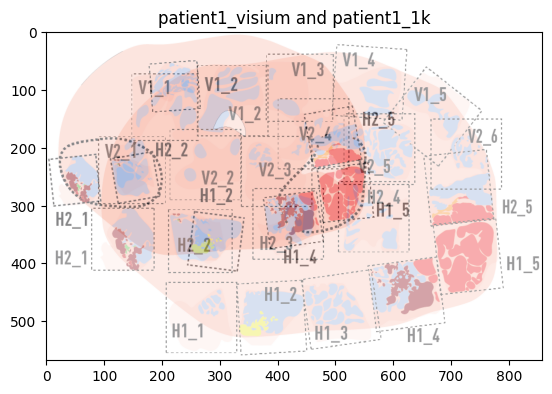

In [61]:
plt.imshow(layout_images["patient1_visium"], alpha=0.8)
plt.imshow(layout_images["patient1_1k"], alpha=0.4)
plt.title("patient1_visium and patient1_1k")

Let's use `napari` to find the landmark points to compute the alignemnt.

In [62]:
layouts_sdata = SpatialData(
    images={
        "layout_patient1_1k": sdata_patient1_1k["layout_patient1_1k"].copy(),
        "layout_patient1_visium": sdata_patient1_visium["layout_patient1_visium"].copy(),
    }
)
layouts_sdata

SpatialData object with:
└── Images
      ├── 'layout_patient1_1k': SpatialImage[cyx] (3, 568, 858)
      └── 'layout_patient1_visium': SpatialImage[cyx] (3, 439, 628)
with coordinate systems:
▸ 'patient1_1k', with elements:
        layout_patient1_1k (Images)
▸ 'patient1_visium', with elements:
        layout_patient1_visium (Images)

In [63]:
landmarks_layout_patient1_visium = PointsModel.parse(
    np.array([[166, 21], [329, 4], [476, 53], [547, 173], [521, 333], [429, 365], [202, 384], [21, 236]])
)

landmarks_layout_patient1_1k = PointsModel.parse(
    np.array([[281, 57], [494, 36], [686, 102], [776, 256], [738, 465], [616, 504], [325, 526], [97, 334]])
)

In [64]:
layout_affine = align_elements_using_landmarks(
    references_coords=landmarks_layout_patient1_1k,
    moving_coords=landmarks_layout_patient1_visium,
    reference_element=layouts_sdata["layout_patient1_1k"],
    moving_element=layouts_sdata["layout_patient1_visium"],
    reference_coordinate_system="patient1_1k",
    moving_coordinate_system="patient1_visium",
    new_coordinate_system="patient1",
    write_to_sdata=None,
)

<img src="attachments/lundeberg_aligned_layouts.png" width="50%">

Let's now use this alignment to align all the images and shapes of `patient1_1k` and `patient1_visium` into the new coordinate system `patient1`.

In [65]:
# we use an identity for sdata_patient1_1k since we use it as a reference
from spatialdata import SpatialData
from spatialdata.transformations import BaseTransformation, Sequence


def postpone_transformation(
    sdata: SpatialData,
    transformation: BaseTransformation,
    source_coordinate_system: str,
    target_coordinate_system: str,
):
    for element_type, element_name, element in sdata._gen_elements():
        old_transformations = get_transformation(element, get_all=True)
        if source_coordinate_system in old_transformations:
            old_transformation = old_transformations[source_coordinate_system]
            sequence = Sequence([old_transformation, transformation])
            set_transformation(element, sequence, target_coordinate_system)


postpone_transformation(
    sdata=sdata_patient1_1k,
    transformation=Identity(),
    source_coordinate_system="patient1_1k",
    target_coordinate_system="patient1",
)

postpone_transformation(
    sdata=sdata_patient1_visium,
    transformation=layout_affine,
    source_coordinate_system="patient1_visium",
    target_coordinate_system="patient1",
)

## Visualizations

Let's end with some plots that show the aligned data.

See how the expression data is tightly aligned to the reference schematics.

<img src="attachments/lundeberg_a.png" width="100%">

We can now visualize interactively also both the Visium and 1k data together.

<img src="attachments/lundeberg_b.png" width="100%">

Here is an example of interactively viewing the Visium gene expression (gene HSP90B1) from all the samples with `napari-spatialdata`.

<img src="attachments/lundeberg_c.png" width="100%">

Thanks to the multiscale representation can view all the large images simultaneously.

<img src="attachments/lundeberg_d.png" width="100%">

And performantly zoom up to the largest resolution. Here we show cell types information plotted on top of images at various zoom levels.

<img src="attachments/lundeberg_e.png" width="100%">
<img src="attachments/lundeberg_f.png" width="100%">
<img src="attachments/lundeberg_g.png" width="100%">